# Hyper Parameter Optimization for Elastic Net

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\Scripts_git\\SingleModels\\ElasticNet'

In [5]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.draw import plot_feature_importance, plot_feature_importance
from Utools.SingleModel import SingleModel

In [8]:
from sklearn.base import clone
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold

## Load Data

In [6]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [ ]:
# using grid search to find the best hyperparameters for the dft model
print("['DFT ElasticNet'] HP optimazation begin...")
# define the parameter grid for ElasticNet
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an ElasticNet model
elastic_net = ElasticNet(max_iter=3000, random_state=RANDOM_SEED)
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=elastic_net, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(dft_train_X, dft_train_y)

['ElasticNet'] HP optimazation begin...
Fitting 5 folds for each of 42 candidates, totalling 210 fits


e:\software2\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e+03, tolerance: 1.014e+01
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=ElasticNet(max_iter=3000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [12]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_alpha', 'param_l1_ratio', 'train_rmse', 'test_rmse']]
results_sorted.head()

Best Hyperparameters: {'alpha': 0.01, 'l1_ratio': 0.05}
Best Cross-Validation RMSE: 1.1307


,rank_test_score,param_alpha,param_l1_ratio,train_rmse,test_rmse
0,1,0.01,0.05,1.128501,1.130659
1,2,0.01,0.10,1.129021,1.131150
2,3,0.01,0.30,1.131708,1.133730
3,4,0.01,0.50,1.133972,1.135754
7,5,0.05,0.05,1.134523,1.136257


### Overfitting check

####################################################################################################
[DFT - ElasticNet] Training ElasticNet on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   6.7s
Model training completed!
[Train_error] Evaluating DFT ElasticNet on DFT train set:


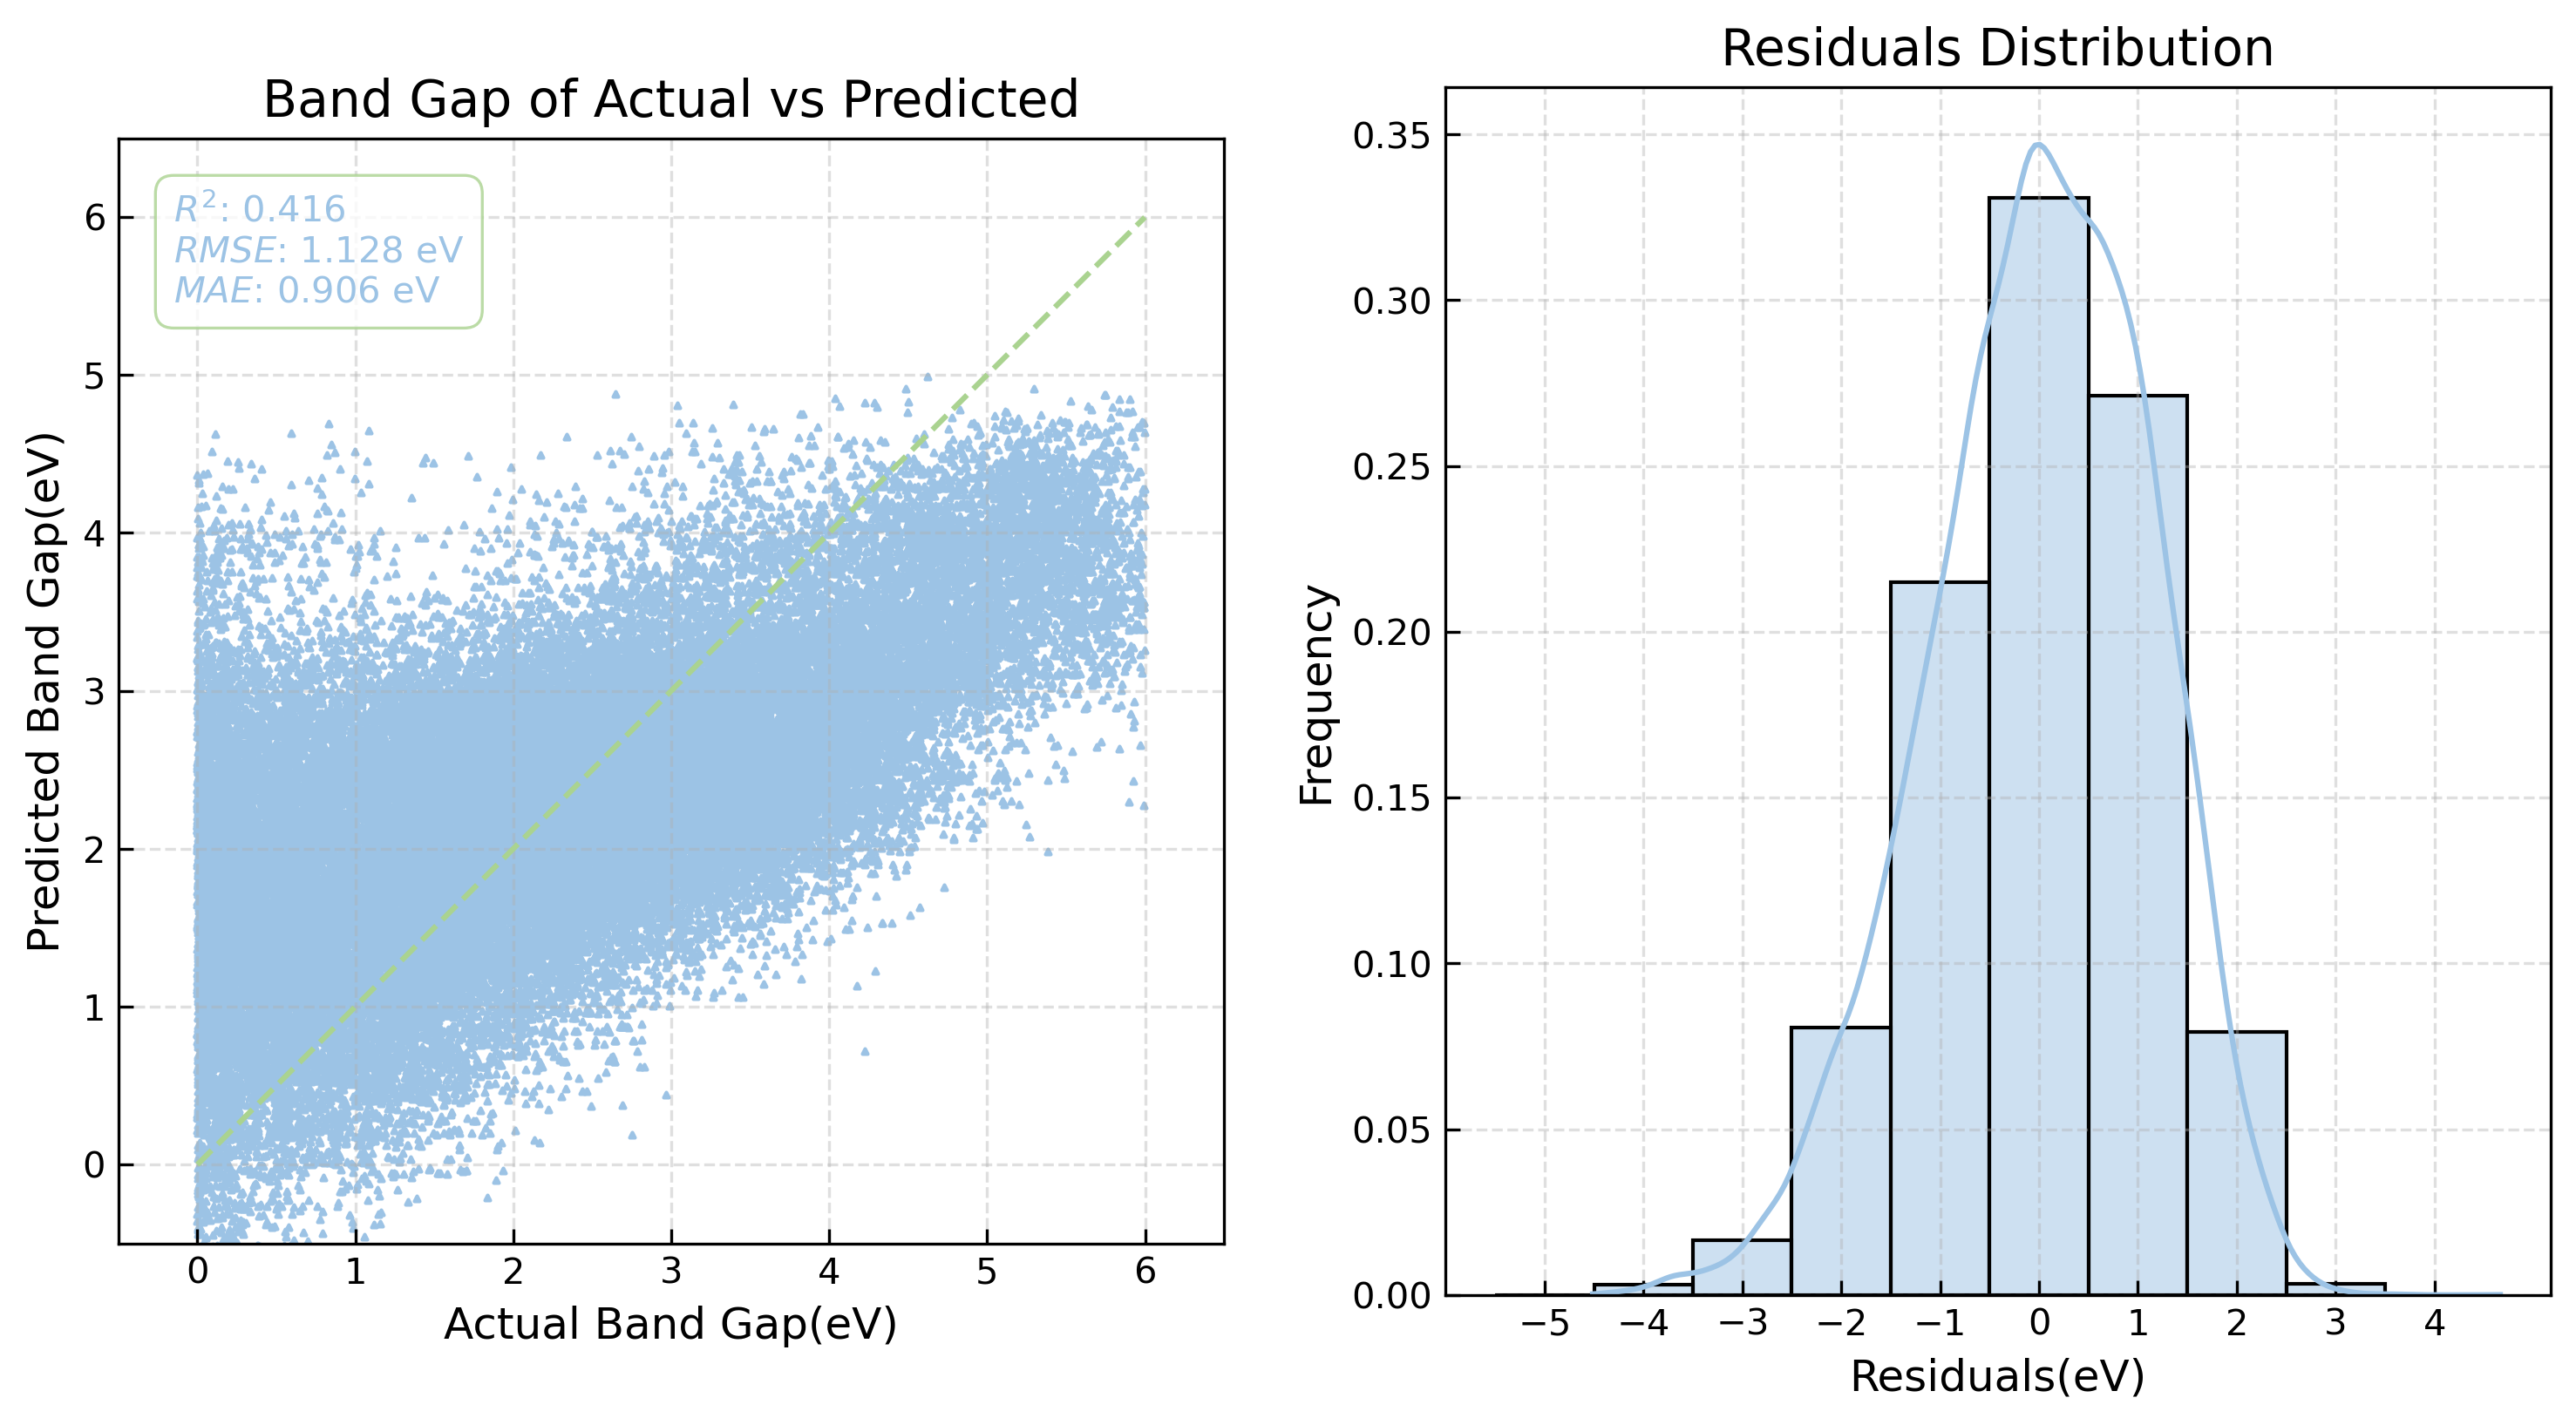


Model Evaluation Results:
Test set: R²: 0.4165 RMSE: 1.1280 MAE: 0.9061
[Test DFT -> DFT] Evaluating DFT ElasticNet on DFT test set:


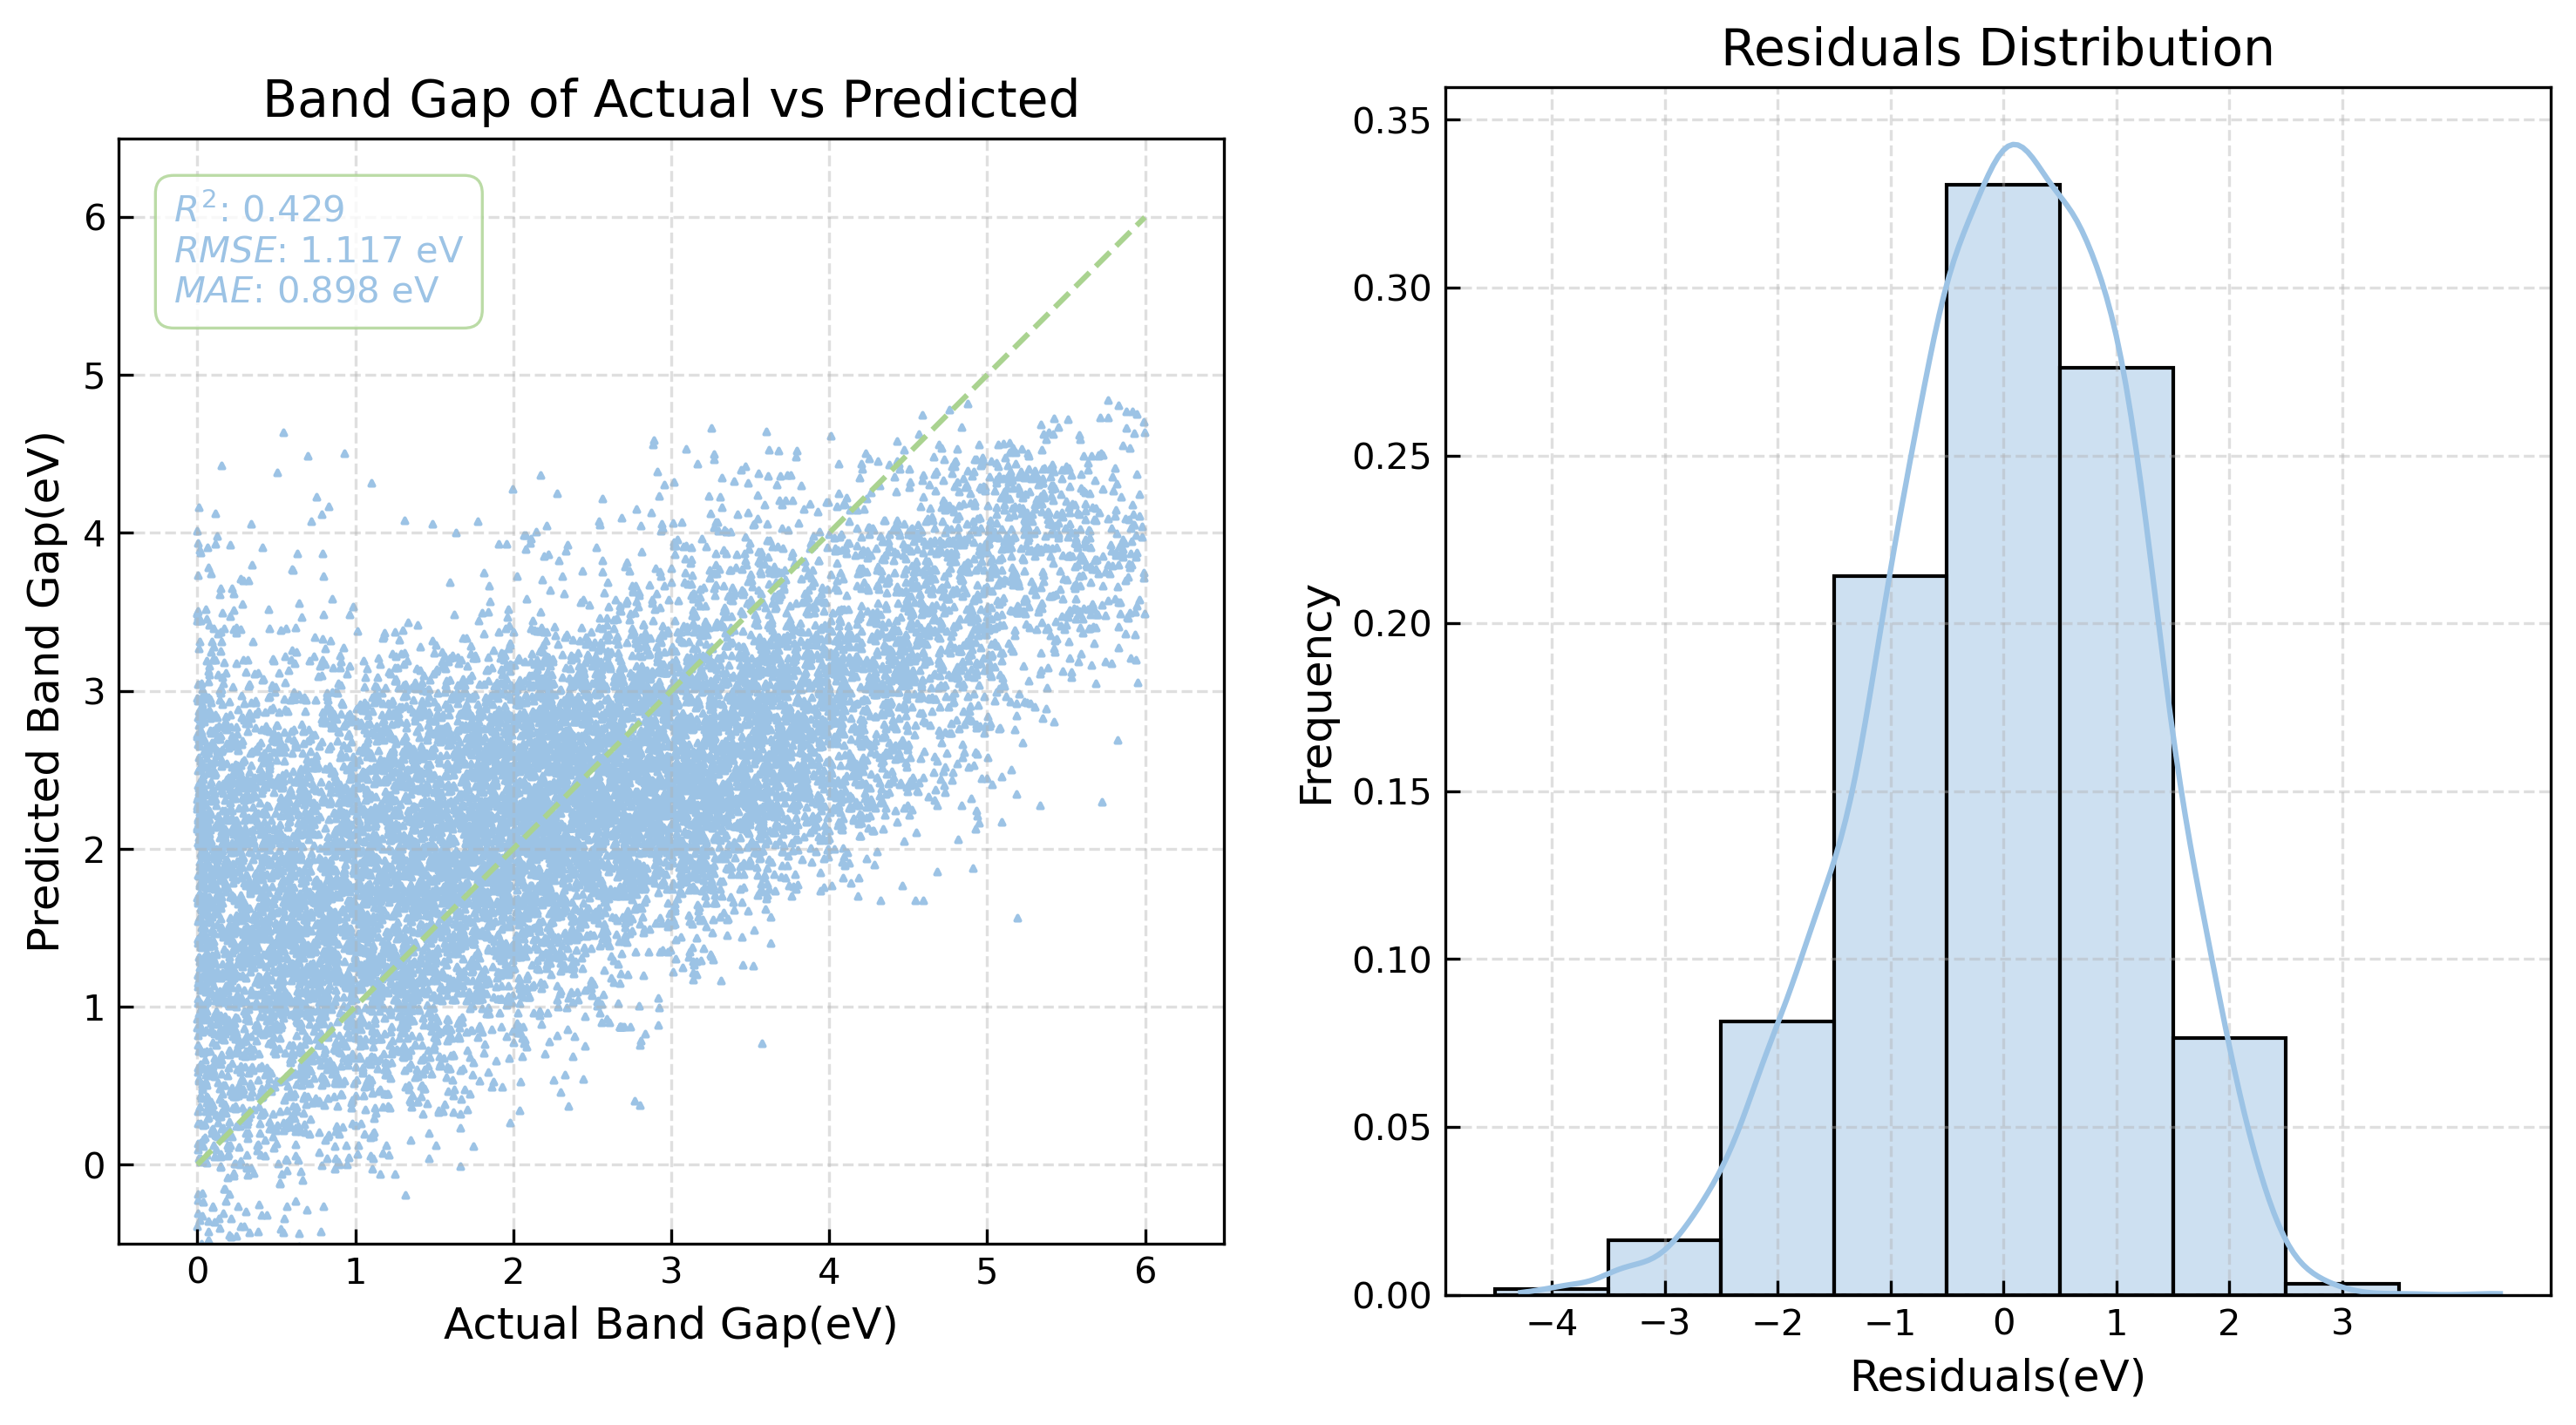


Model Evaluation Results:
Test set: R²: 0.4294 RMSE: 1.1165 MAE: 0.8978
[Test DFT -> EXP] Evaluating DFT ElasticNet on EXP test set:


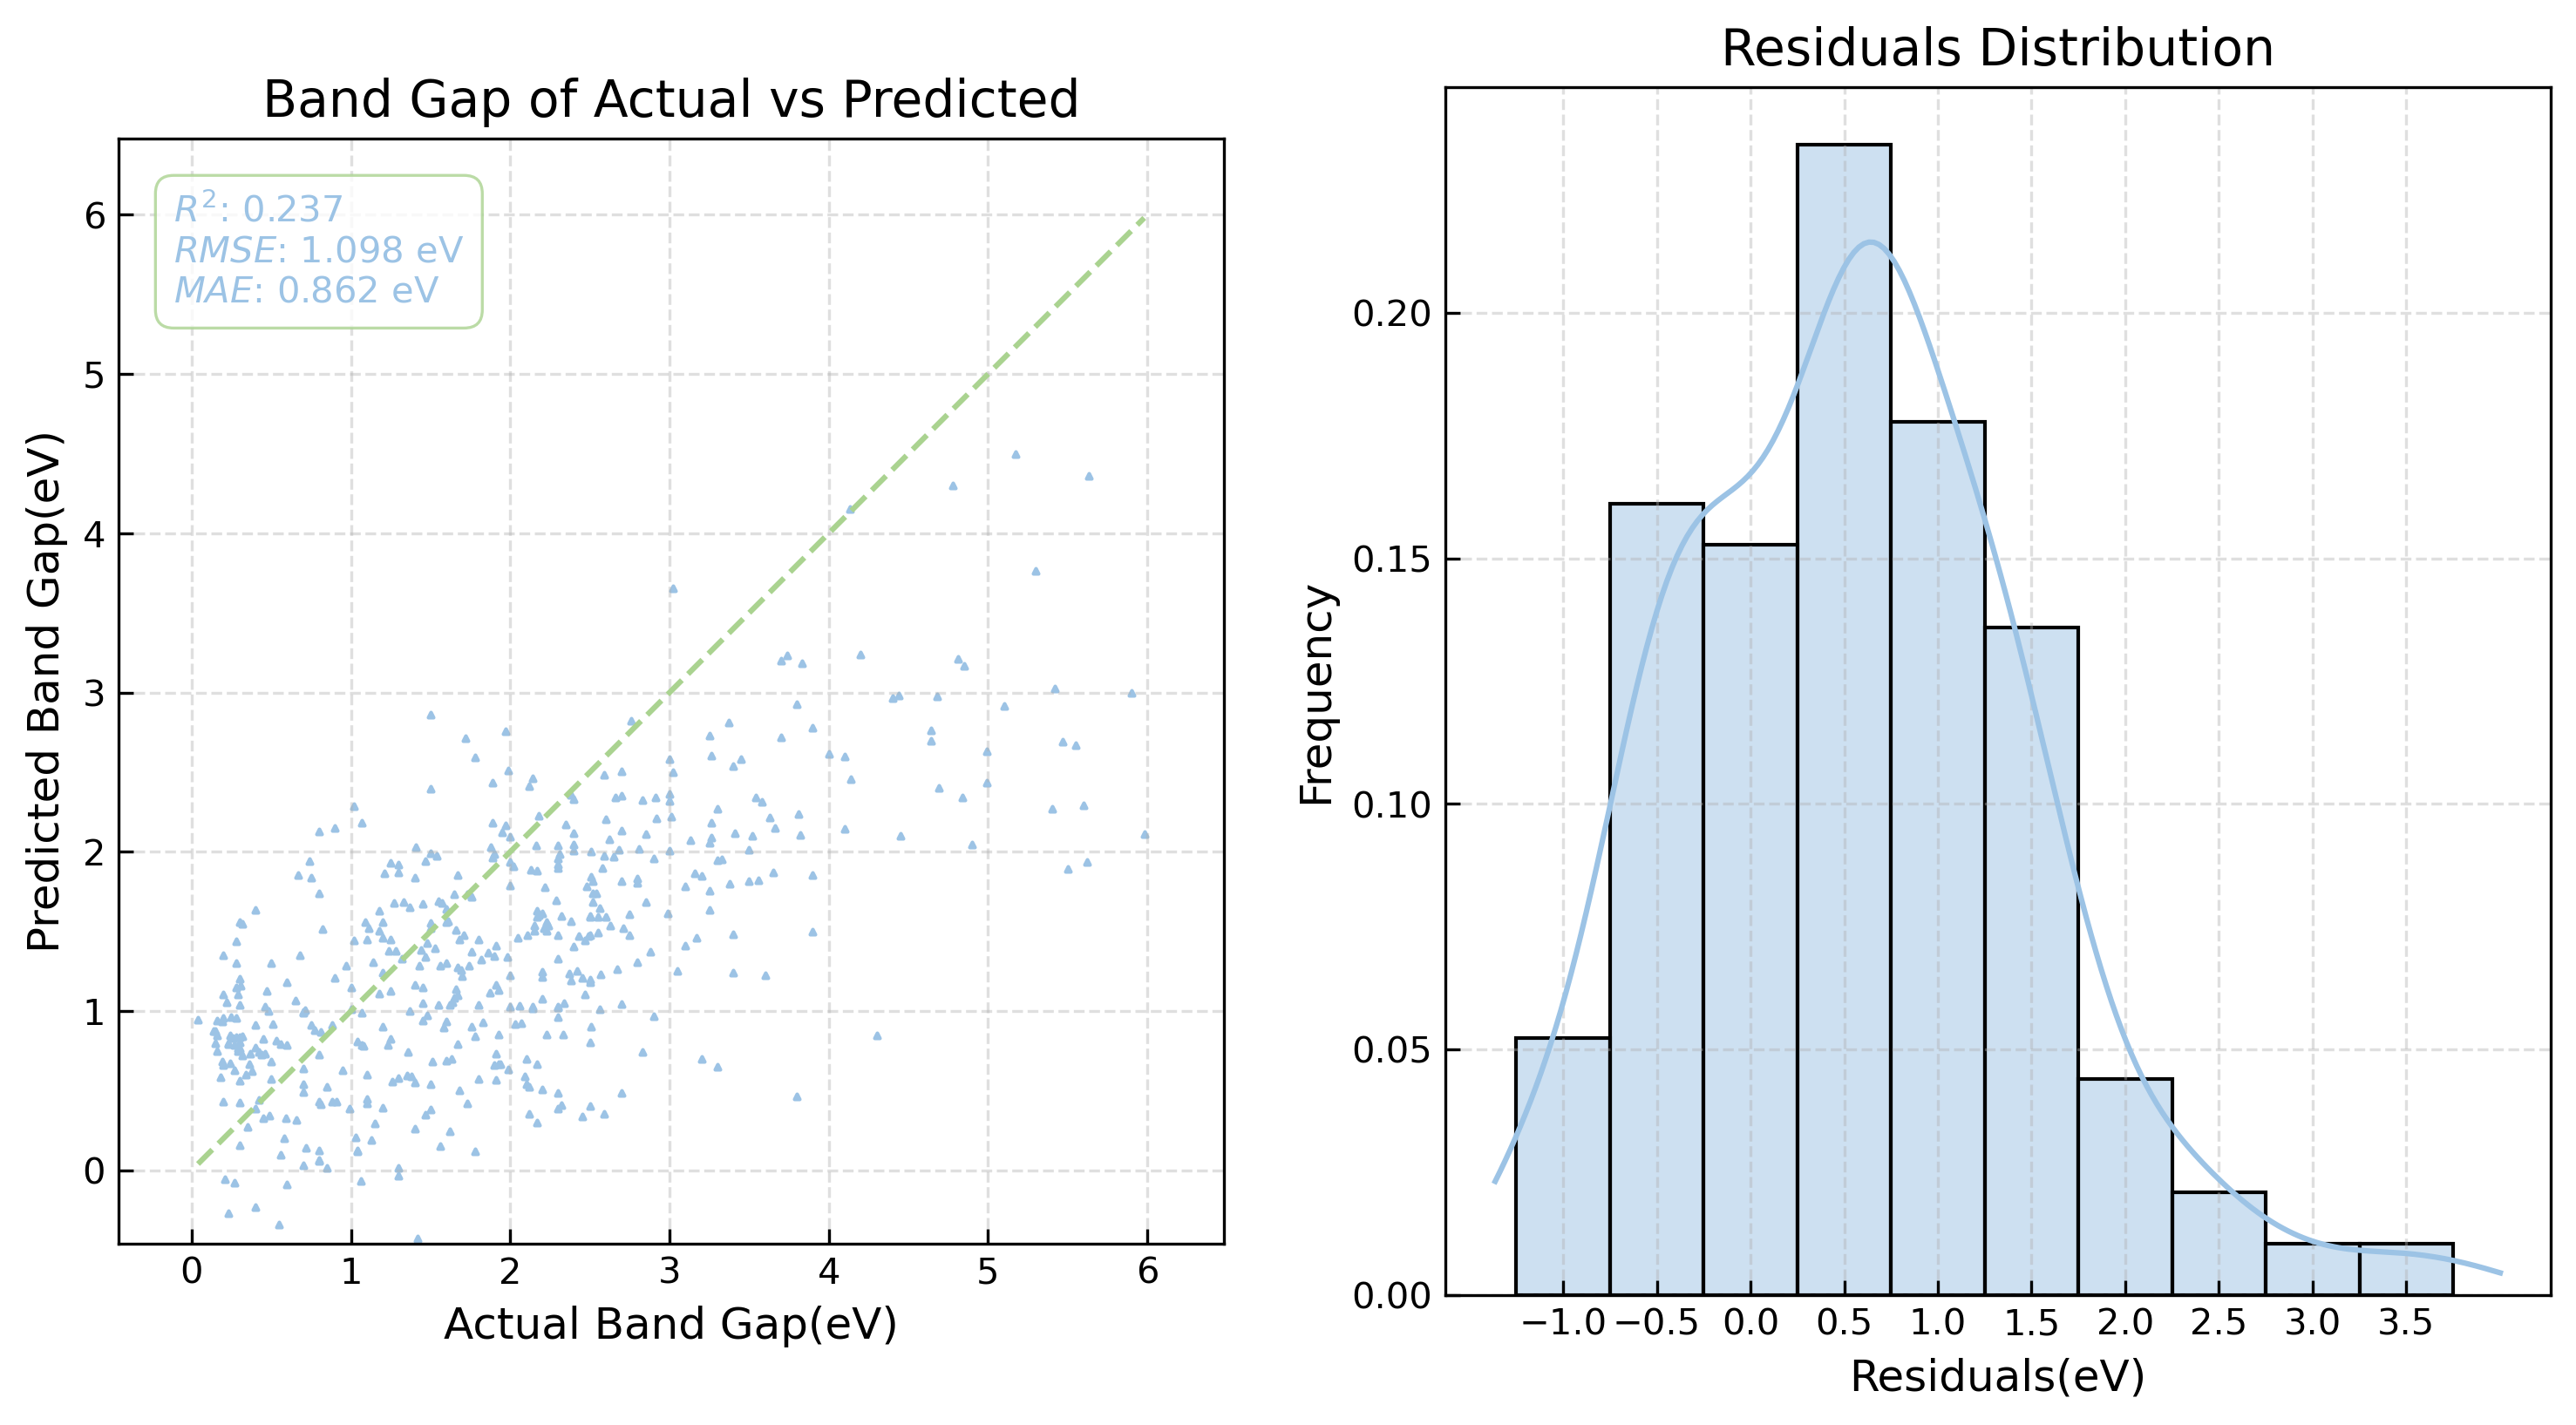


Model Evaluation Results:
Test set: R²: 0.2366 RMSE: 1.0980 MAE: 0.8615


In [ ]:
# 
# Train the model with the best hyperparameters on the entire training set
model_name = 'ElasticNet'
elastic_net_best = ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=10000, random_state=RANDOM_SEED)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {model_name}] Training {model_name} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(elastic_net_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {model_name} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {model_name} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {model_name} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [20]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,ElasticNet,NaN,dft,dft,0.416466,1.127998,0.906095
1,ElasticNet,Test,dft,dft,0.429443,1.116509,0.897839
2,ElasticNet,Test,dft,exp,0.236563,1.098023,0.861543


### EXP Model

In [21]:
# using grid search to find the best hyperparameters for the dft model
print("['EXP ElasticNet'] HP optimazation begin...")
# define the parameter grid for ElasticNet
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an ElasticNet model
elastic_net = ElasticNet(max_iter=10000, random_state=RANDOM_SEED)
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=elastic_net, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)

['EXP ElasticNet'] HP optimazation begin...
Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=ElasticNet(max_iter=10000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [22]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_alpha', 'param_l1_ratio', 'train_rmse', 'test_rmse']]
results_sorted.head()

Best Hyperparameters: {'alpha': 0.01, 'l1_ratio': 0.05}
Best Cross-Validation RMSE: 0.7363


,rank_test_score,param_alpha,param_l1_ratio,train_rmse,test_rmse
0,1,0.01,0.05,0.687768,0.736261
1,2,0.01,0.10,0.689239,0.737516
2,3,0.01,0.30,0.695905,0.743321
3,4,0.01,0.50,0.703272,0.747582
4,5,0.01,0.70,0.709751,0.751579


### Overfitting check

####################################################################################################
[EXP - ElasticNet] Training ElasticNet on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
Model training completed!
[Train_error] Evaluating EXP ElasticNet on EXP train set:


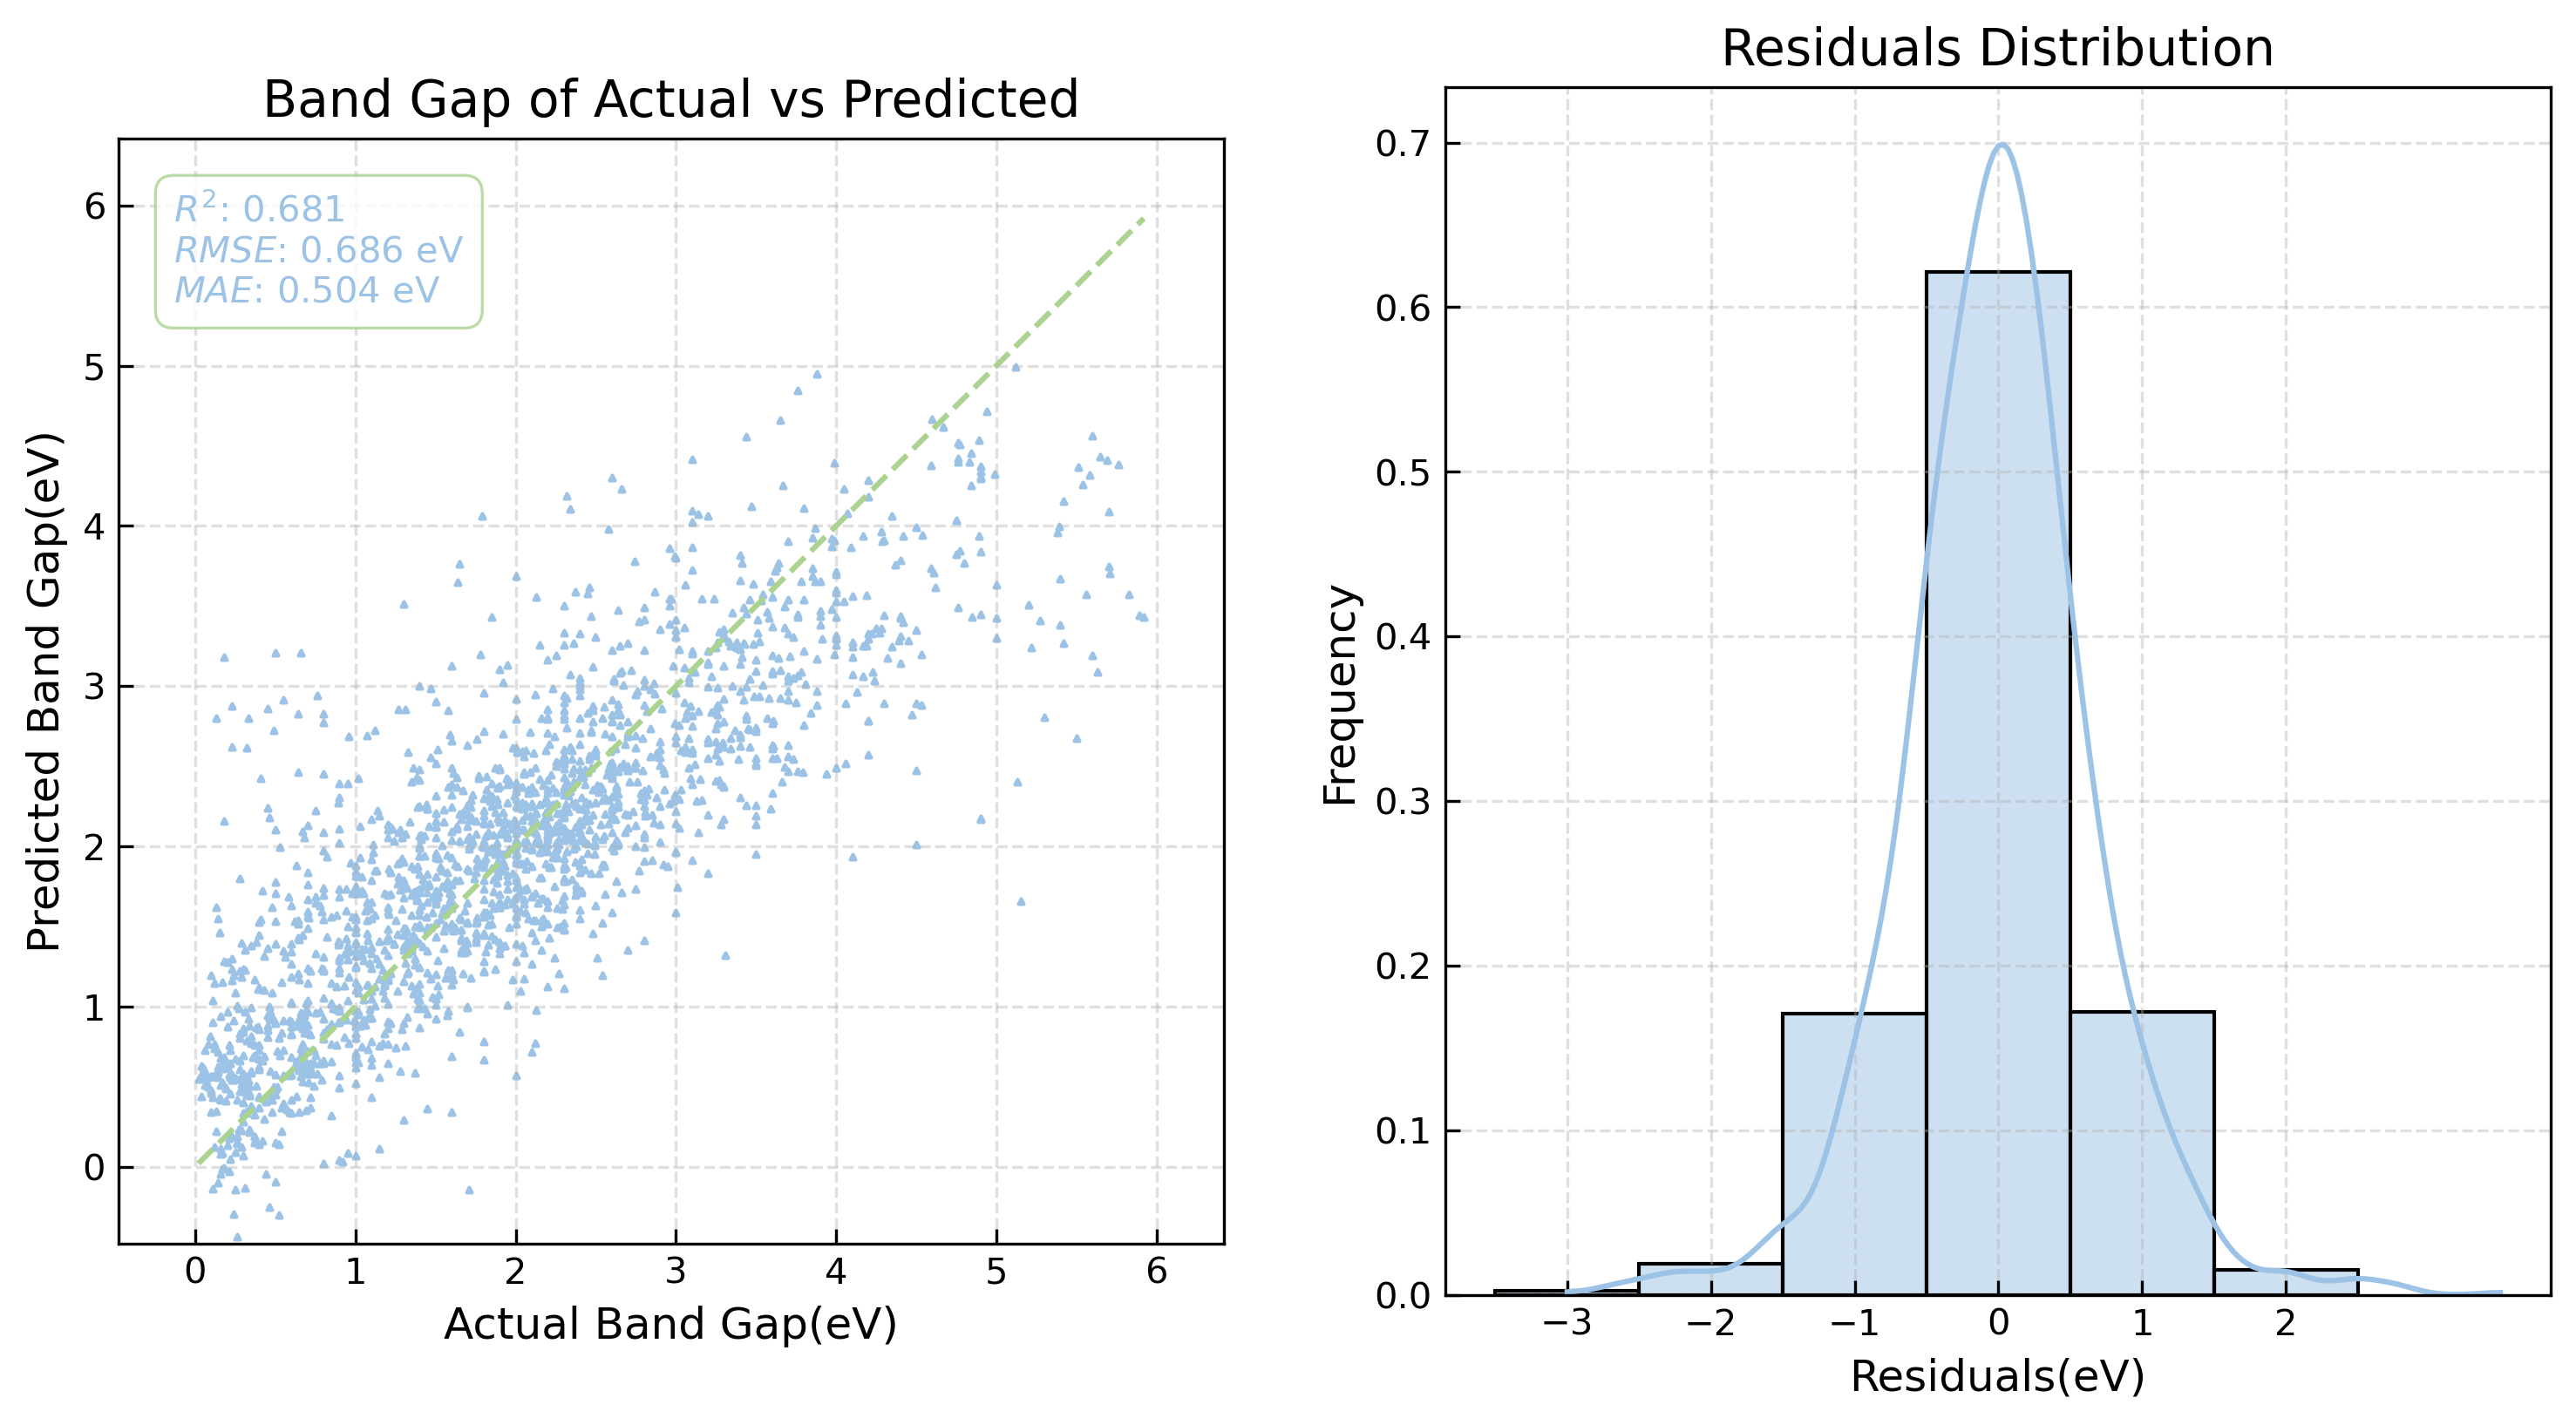


Model Evaluation Results:
Test set: R²: 0.6805 RMSE: 0.6858 MAE: 0.5042
[Test EXP -> EXP] Evaluating EXP ElasticNet on EXP test set:


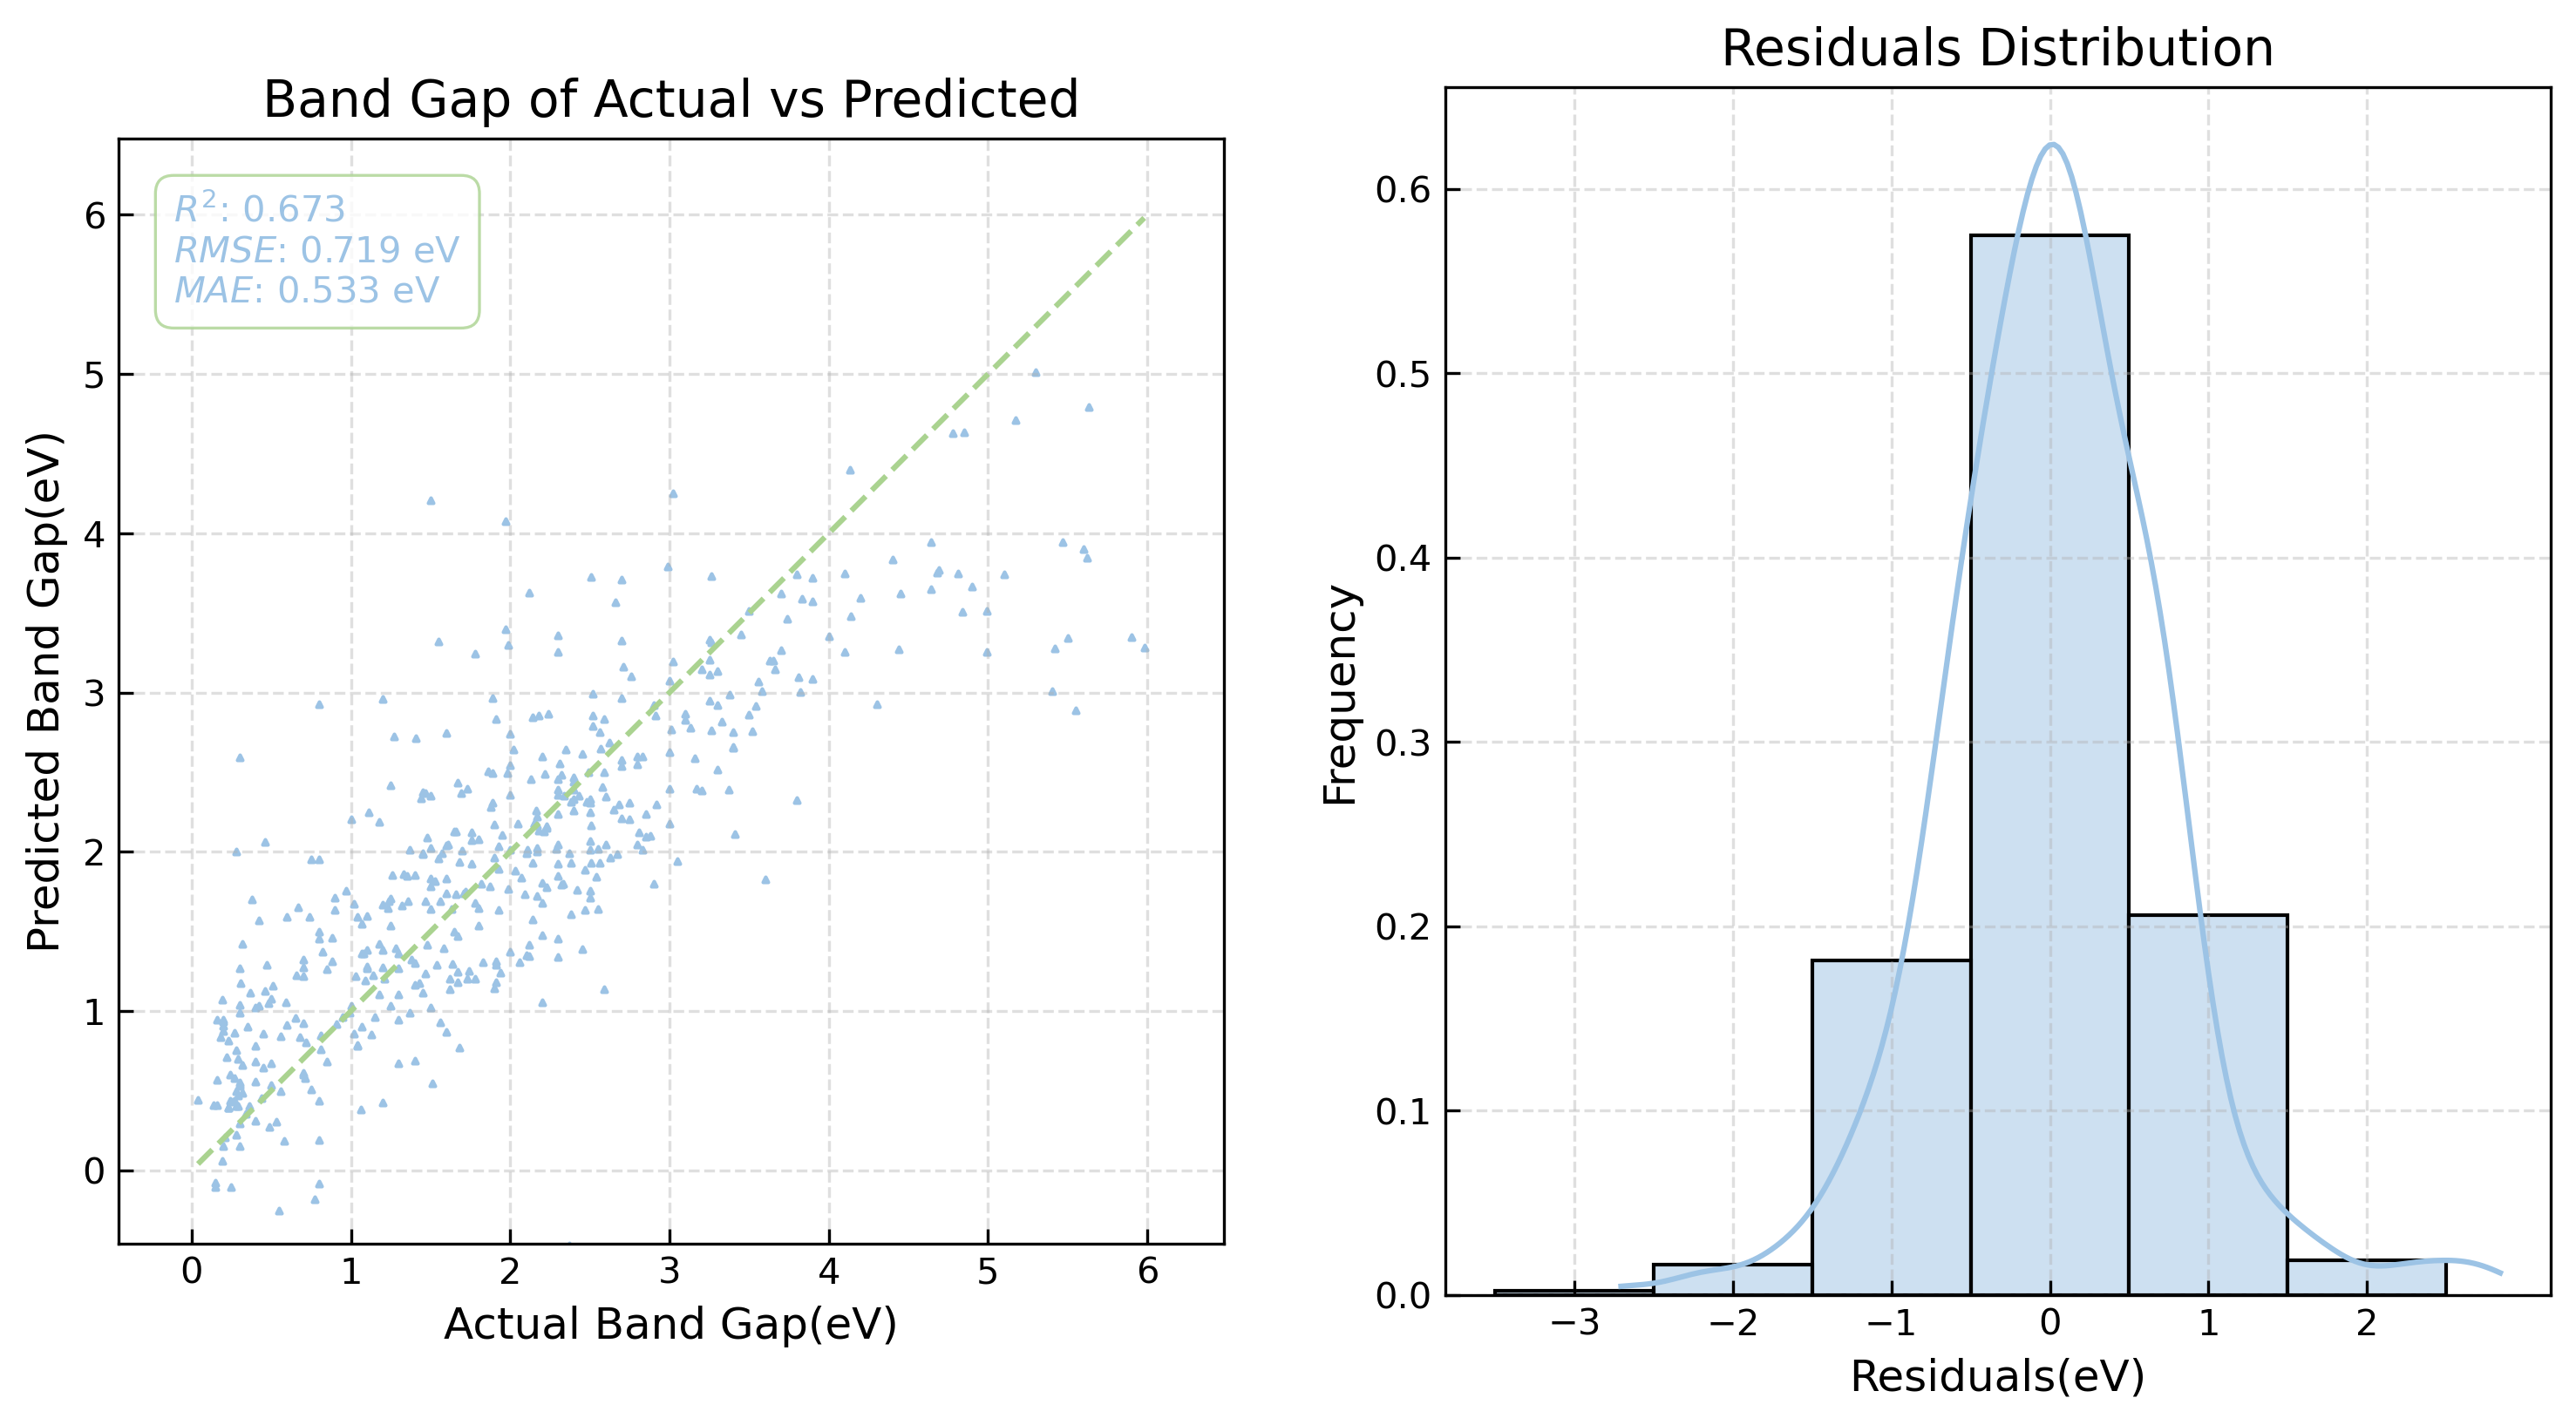


Model Evaluation Results:
Test set: R²: 0.6726 RMSE: 0.7191 MAE: 0.5329
[Test EXP -> DFT] Evaluating EXP ElasticNet on DFT test set:


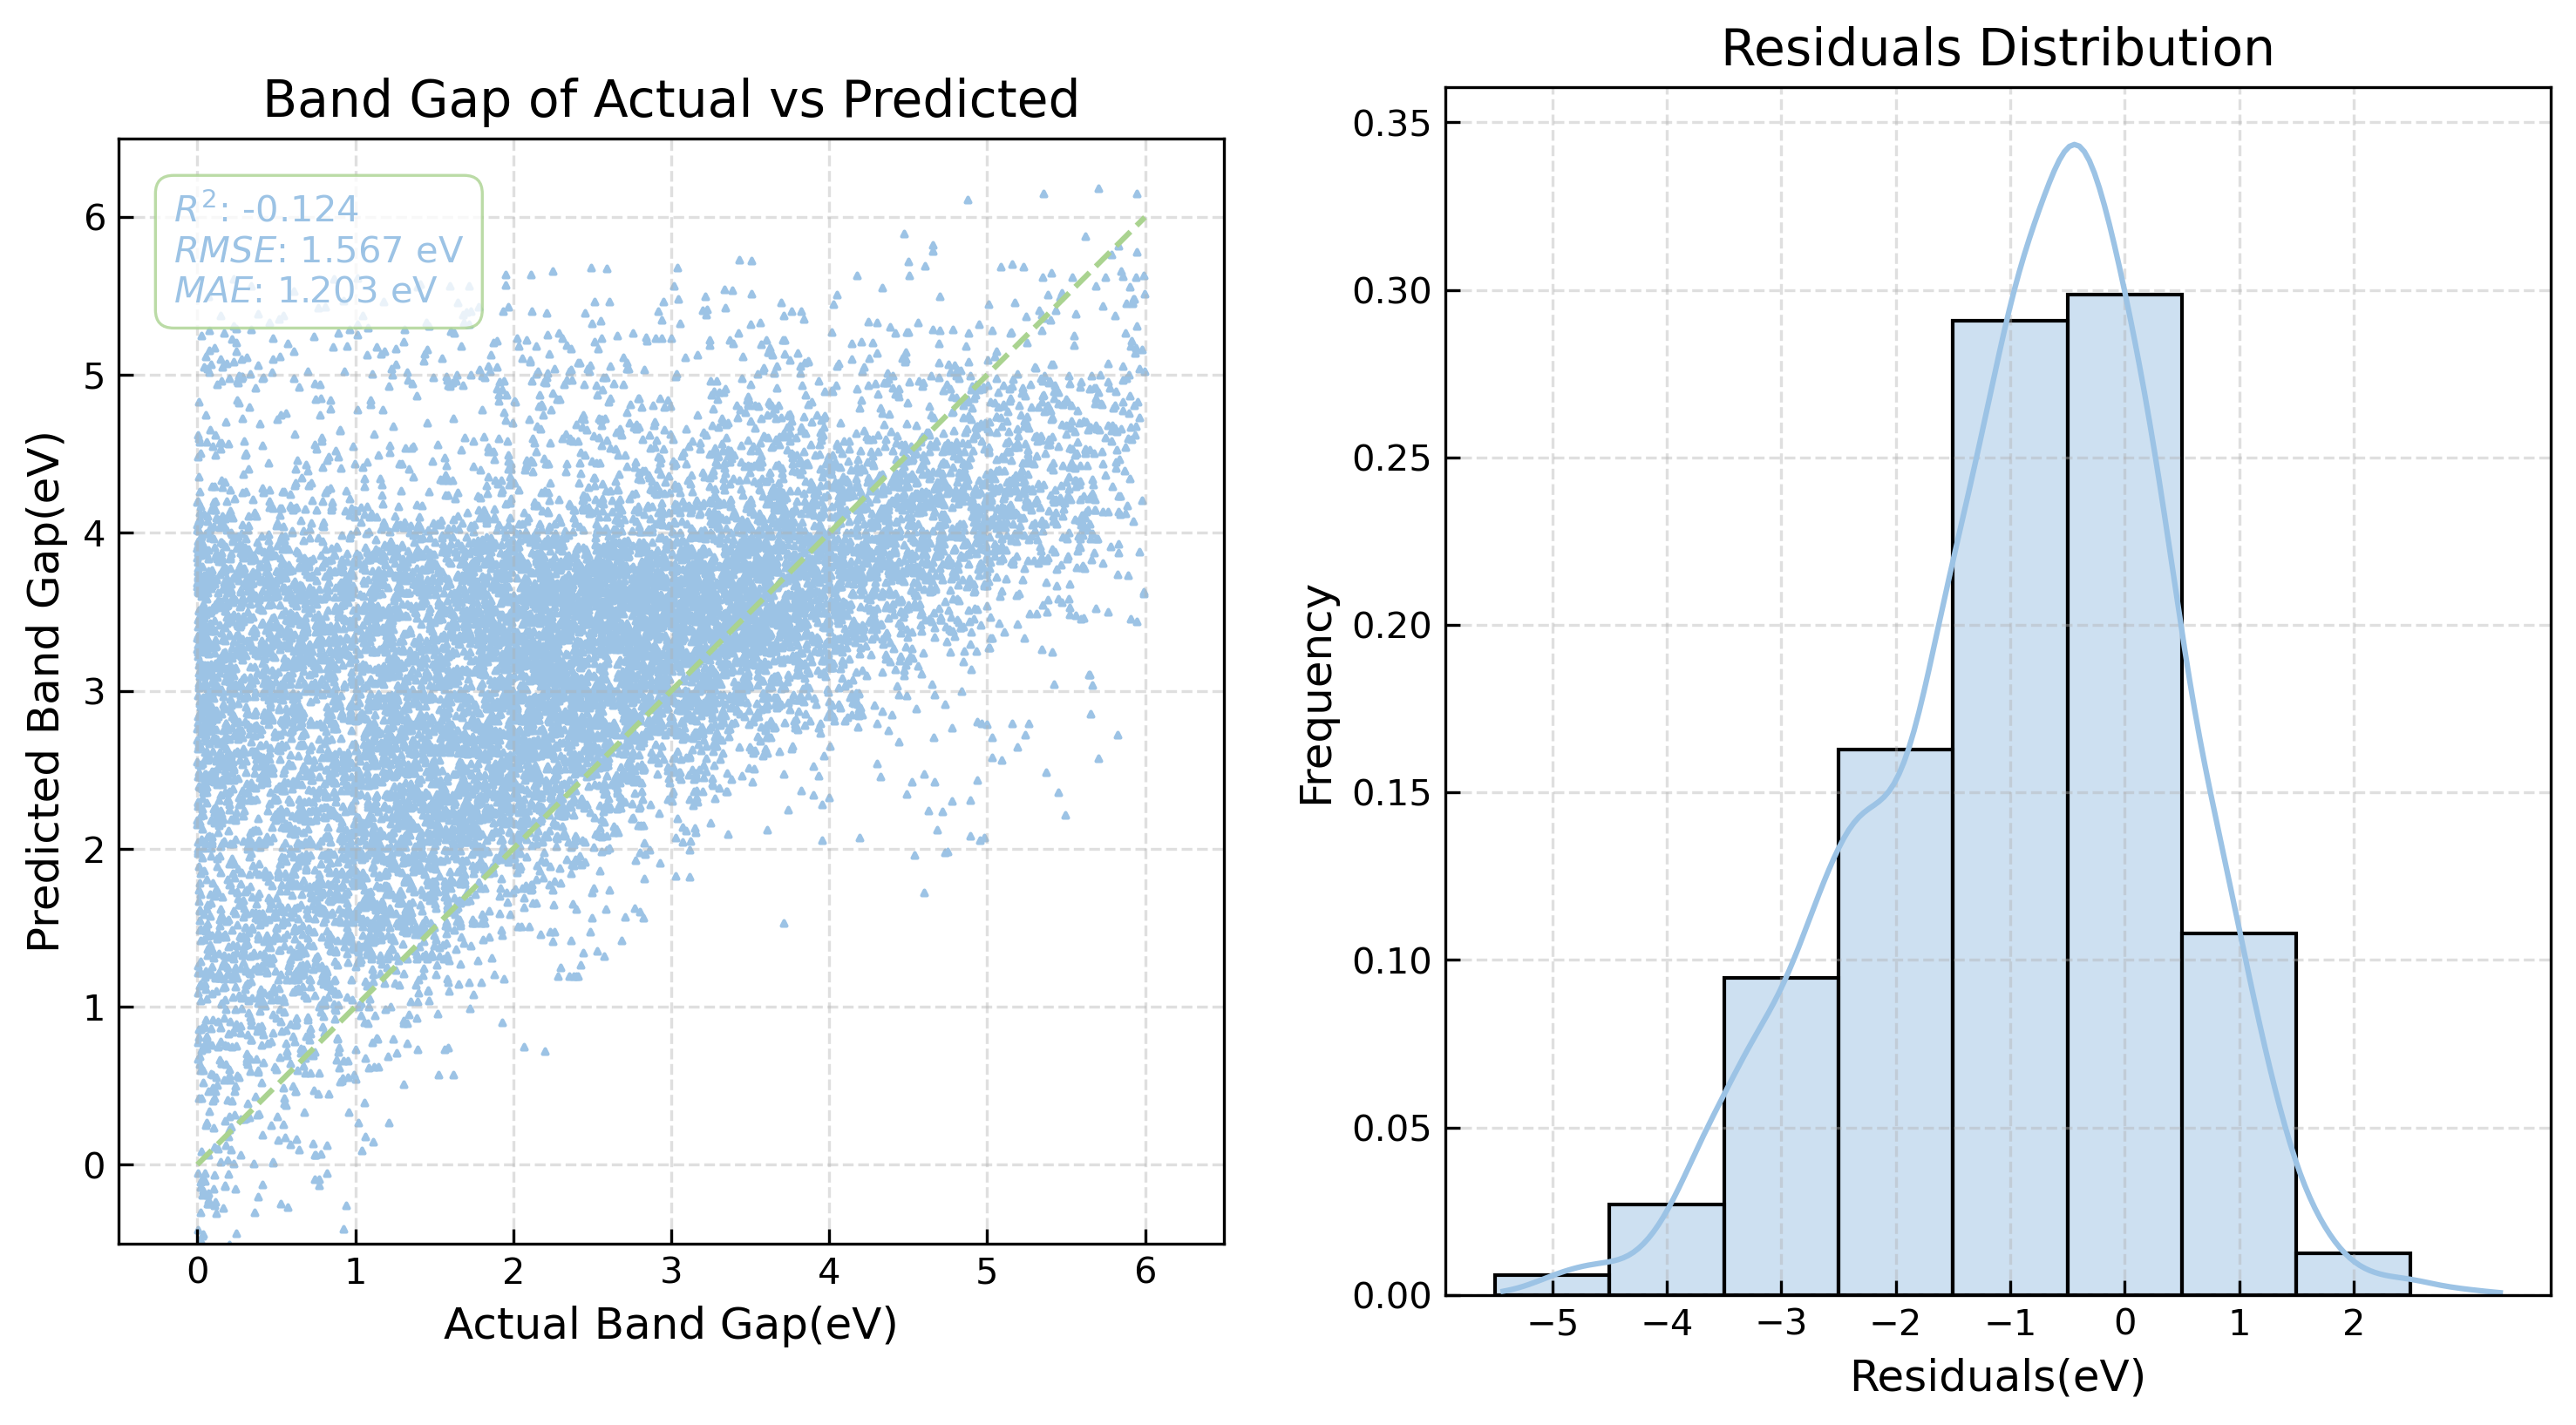


Model Evaluation Results:
Test set: R²: -0.1235 RMSE: 1.5668 MAE: 1.2027


In [27]:
# 
# Train the model with the best hyperparameters on the entire training set
model_name = 'ElasticNet'
elastic_net_best = ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=10000, random_state=RANDOM_SEED)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {model_name}] Training {model_name} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(elastic_net_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {model_name} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {model_name} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {model_name} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': model_name,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [28]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,ElasticNet,Train,exp,exp,0.680536,0.685794,0.504202
1,ElasticNet,Test,exp,exp,0.672597,0.719062,0.532891
2,ElasticNet,Test,exp,dft,-0.123515,1.566758,1.202668
